In [1]:
SEED = 42
BATCH_SIZE = 128
EPOCHS = 50
DATA_DIR = 'flowers'
INPUT_SHAPE = (160, 160, 3)

In [2]:
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    batch_size = BATCH_SIZE,
    seed = SEED,
    target_size = (160, 160),
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    shuffle = False,
    batch_size = BATCH_SIZE,
    seed = SEED,
    target_size = (160, 160),
    class_mode = 'categorical',
    subset = 'validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [3]:
import pandas as pd

class_names = train_generator.class_indices

class_df = pd.DataFrame.from_dict(class_names, orient='index', columns=['id'])

class_df.head()

,id
daisy,0
dandelion,1
rose,2
sunflower,3
tulip,4


In [4]:
model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE)
model.trainable = False

input_layer = tf.keras.Input(shape=INPUT_SHAPE)

model_layers = model(input_layer)
model_layers = tf.keras.layers.Flatten()(model_layers)
output_layer = tf.keras.layers.Dense(len(class_df), activation='softmax')(model_layers)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense (Dense)               (None, 5)                 160005    
                                                                 
Total params: 2,417,989
Trainable params: 160,005
Non-trainable params: 2,257,984
_________________________________________________________________


In [5]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.85):
            print("\nTraining dihentikan karena akurasi sudah lebih dari 85%")
            self.model.stop_training = True

callbacks = myCallback()

In [6]:
model.compile(optimizer = 'Adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [7]:
history = model.fit(
    train_generator,
    workers = 8, 
    steps_per_epoch = train_generator.samples // BATCH_SIZE, 
    epochs = EPOCHS, 
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE, 
    callbacks = callbacks)

Epoch 1/50
27/27 [==============================] - 110s 4s/step - loss: 1.5529 - accuracy: 0.7137 - precision: 0.7274 - recall: 0.7077 - val_loss: 1.0503 - val_accuracy: 0.7891 - val_precision: 0.7961 - val_recall: 0.7878
Epoch 2/50
27/27 [==============================] - 102s 4s/step - loss: 0.4991 - accuracy: 0.8922 - precision: 0.8951 - recall: 0.8895 - val_loss: 1.4366 - val_accuracy: 0.7878 - val_precision: 0.7919 - val_recall: 0.7878
Epoch 3/50
27/27 [==============================] - 102s 4s/step - loss: 0.3731 - accuracy: 0.9252 - precision: 0.9265 - recall: 0.9240 - val_loss: 0.9171 - val_accuracy: 0.8464 - val_precision: 0.8508 - val_recall: 0.8464
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9772 - precision: 0.9780 - recall: 0.9769
Training dihentikan karena akurasi sudah lebih dari 85%
27/27 [==============================] - 102s 4s/step - loss: 0.0699 - accuracy: 0.9772 - precision: 0.9780 - recall: 0.9769 - val_loss: 0.8763 

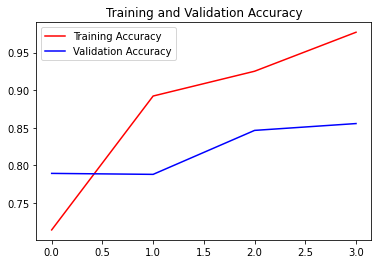

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')

plt.legend(loc=0)
plt.figure()

plt.show()

In [9]:
from sklearn.metrics import classification_report
import numpy as np

probas = model.predict(validation_generator)
y_pred = np.argmax(probas, axis=1)
y_true = validation_generator.classes

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       152
           1       0.92      0.83      0.88       210
           2       0.81      0.84      0.83       156
           3       0.76      0.91      0.83       146
           4       0.88      0.78      0.83       196

    accuracy                           0.86       860
   macro avg       0.85      0.86      0.86       860
weighted avg       0.86      0.86      0.86       860



In [10]:
model.save("mobilnetflowzy.h5")

C:\Users\peija\anaconda3\envs\notebook-6.4.6\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
